# Import

In [ ]:
# base
import pandas as pd
import numpy as np
import os
import torch
import os

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

# preprocessing
from sklearn.preprocessing import LabelEncoder

#Verification
from sklearn.metrics import (precision_recall_curve, roc_curve, make_scorer, log_loss,
                             f1_score, confusion_matrix, auc, roc_auc_score, accuracy_score)
from pytorch_tabnet.metrics import Metric

# set
np.random.seed(0)

#import wget
from pathlib import Path
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
%matplotlib inline

# Data Load

In [6]:
train = pd.read_csv('../Data/test_result_df.csv').drop(['Unnamed: 0'],axis=1).set_index('STD_DT')
test = pd.read_csv('../Data/test_result_df.csv').drop(['Unnamed: 0'],axis=1).set_index('STD_DT')

In [7]:
target = 'TAG'    
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))
    
test['Set'] = 'test'
data = pd.concat([train,test]).reset_index(drop=True)

train_indices = data[data.Set=="train"].index
valid_indices = data[data.Set=="valid"].index
test_indices = data[data.Set=="test"].index

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50400 entries, 2020-03-04 00:00:00 to 2020-04-07 23:59:00
Data columns (total 62 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MELT_TEMP_00          50400 non-null  float64
 1   MOTORSPEED_00         50400 non-null  float64
 2   MELT_WEIGHT_00        50400 non-null  float64
 3   INSP_00               50400 non-null  float64
 4   Measurement_error_00  50400 non-null  float64
 5   MW_Period_Second_00   50400 non-null  float64
 6   MELT_TEMP_06          50400 non-null  float64
 7   MOTORSPEED_06         50400 non-null  float64
 8   MELT_WEIGHT_06        50400 non-null  float64
 9   INSP_06               50400 non-null  float64
 10  Measurement_error_06  50400 non-null  float64
 11  MW_Period_Second_06   50400 non-null  float64
 12  MELT_TEMP_12          50400 non-null  float64
 13  MOTORSPEED_12         50400 non-null  float64
 14  MELT_WEIGHT_12        50400 non-null  float

# Preprocessing

In [9]:
nunique = data.nunique()
types = data.dtypes

categorical_columns = []
categorical_dims =  {}
for col in data.columns:
    if types[col] == 'object' or nunique[col] < 250:
        print(col, data[col].nunique())
        l_enc = LabelEncoder()
        data[col] = data[col].fillna("VV_likely")
        data[col] = l_enc.fit_transform(data[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        data.fillna(data.loc[train_indices, col].mean(), inplace=True)


# Categorical Embedding을 위해 Categorical 변수의 차원과 idxs를 담음.
unused_feat = ['Set']
features = [ col for col in data.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]



X_train = data[features].values[train_indices]
y_train = data[target].values[train_indices]

X_valid = data[features].values[valid_indices]
y_valid = data[target].values[valid_indices]

X_test = data[features].values[test_indices]
y_test = data[target].values[test_indices]

MELT_TEMP_00 148
MOTORSPEED_00 124
INSP_00 4
Measurement_error_00 2
MELT_TEMP_06 151
MOTORSPEED_06 79
INSP_06 4
Measurement_error_06 2
MELT_TEMP_12 150
MOTORSPEED_12 127
INSP_12 4
Measurement_error_12 2
MELT_TEMP_18 148
MOTORSPEED_18 120
INSP_18 4
Measurement_error_18 2
MELT_TEMP_24 149
MOTORSPEED_24 124
INSP_24 4
Measurement_error_24 2
MELT_TEMP_30 151
MOTORSPEED_30 122
INSP_30 4
Measurement_error_30 2
MELT_TEMP_36 151
MOTORSPEED_36 120
INSP_36 4
Measurement_error_36 2
MELT_TEMP_42 147
MOTORSPEED_42 123
INSP_42 4
Measurement_error_42 2
MELT_TEMP_48 154
MOTORSPEED_48 77
INSP_48 3
Measurement_error_48 2
MELT_TEMP_54 151
MOTORSPEED_54 120
INSP_54 4
Measurement_error_54 2
TAG 2
Set 3


# TabNet

In [10]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    mask_type='entmax' # "sparsemax"
)

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [11]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_test],
    pretraining_ratio=0.8,
)

epoch 0  | loss: 10.20664| val_0_unsup_loss_numpy: 8.18136978149414|  0:00:06s
epoch 1  | loss: 6.08882 | val_0_unsup_loss_numpy: 5.754459857940674|  0:00:10s
epoch 2  | loss: 3.53186 | val_0_unsup_loss_numpy: 2.9631900787353516|  0:00:14s
epoch 3  | loss: 1.983   | val_0_unsup_loss_numpy: 2.4399499893188477|  0:00:19s
epoch 4  | loss: 1.82303 | val_0_unsup_loss_numpy: 2.3099899291992188|  0:00:23s
epoch 5  | loss: 1.74192 | val_0_unsup_loss_numpy: 2.2235500812530518|  0:00:27s
epoch 6  | loss: 1.68246 | val_0_unsup_loss_numpy: 2.1512300968170166|  0:00:32s
epoch 7  | loss: 1.63179 | val_0_unsup_loss_numpy: 2.085930109024048|  0:00:36s
epoch 8  | loss: 1.57999 | val_0_unsup_loss_numpy: 2.0193800926208496|  0:00:40s
epoch 9  | loss: 1.53503 | val_0_unsup_loss_numpy: 1.9562499523162842|  0:00:44s
epoch 10 | loss: 1.4913  | val_0_unsup_loss_numpy: 1.9056299924850464|  0:00:48s
epoch 11 | loss: 1.45636 | val_0_unsup_loss_numpy: 1.8576099872589111|  0:00:53s
epoch 12 | loss: 1.42078 | val_0

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [12]:
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax' # This will be overwritten if using pretrain model
)

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [13]:
class F1Score(Metric):
    def __init__(self):
        self._name = "f1"
        self._maximize = True
    
    def __call__(self, y_true, y_score):
        y_score = (y_score[:, 1] > 0.5).astype(np.uint8)
        return f1_score(y_true, y_score)

In [14]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy', 'f1'],
    from_unsupervised=unsupervised_model
)

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.88042 | train_accuracy: 0.62233 | train_f1: 0.76313 | valid_accuracy: 0.28578 | valid_f1: 0.43367 |  0:00:04s
epoch 1  | loss: 0.64914 | train_accuracy: 0.62342 | train_f1: 0.76576 | valid_accuracy: 0.284   | valid_f1: 0.43653 |  0:00:09s
epoch 2  | loss: 0.6468  | train_accuracy: 0.62028 | train_f1: 0.7612  | valid_accuracy: 0.28536 | valid_f1: 0.43159 |  0:00:13s
epoch 3  | loss: 0.6454  | train_accuracy: 0.61919 | train_f1: 0.76131 | valid_accuracy: 0.28521 | valid_f1: 0.43356 |  0:00:18s
epoch 4  | loss: 0.64173 | train_accuracy: 0.62521 | train_f1: 0.76875 | valid_accuracy: 0.28219 | valid_f1: 0.43953 |  0:00:22s
epoch 5  | loss: 0.64179 | train_accuracy: 0.62142 | train_f1: 0.75881 | valid_accuracy: 0.28261 | valid_f1: 0.42802 |  0:00:27s
epoch 6  | loss: 0.64051 | train_accuracy: 0.62575 | train_f1: 0.767   | valid_accuracy: 0.28303 | valid_f1: 0.43626 |  0:00:32s
epoch 7  | loss: 0.6374  | train_accuracy: 0.62766 | train_f1: 0.77009 | valid_accuracy: 0.28197 

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [15]:
pred = clf.predict_proba(X_test)

In [16]:
pred_df = pd.DataFrame(pred)
pred_df['target'] = pred_df.iloc[:,0].apply(lambda x: 0 if x > 0.5 else 1)
pred_df

,0,1,target
0,0.439620,0.560380,1
1,0.403256,0.596744,1
2,0.440402,0.559598,1
3,0.434703,0.565297,1
4,0.436518,0.563483,1
...,...,...,...
33115,0.315746,0.684254,1
33116,0.586129,0.413871,0
33117,0.295269,0.704731,1
33118,0.338029,0.661971,1


In [17]:
test_acc = f1_score(y_test,pred_df['target'])
print(test_acc)

0.439530388042812


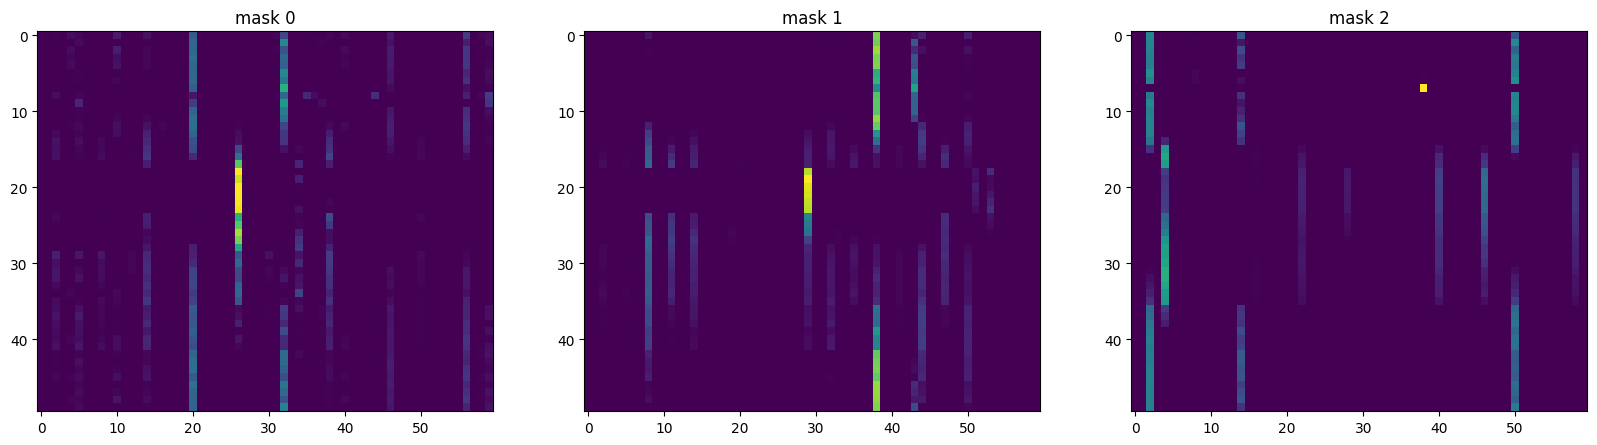

In [18]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")